# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
# Import the class
from xopt import Xopt

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

In [2]:
!mkdir -p temp

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt 
________________________________           
Version: 0.5.0+104.gaf8ee7d.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs: {extra_option: abc, sleep: 0, random_sleep: 0.1}
  max_workers: 1
  executor: NormalExecutor
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [4]:
%%timeit
# Check that the averate time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = 1)

The slowest run took 5.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1.1 s ± 498 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%time
X.run()

CPU times: user 6.83 s, sys: 371 ms, total: 7.2 s
Wall time: 1min 54s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator._executor = executor
    X.evaluator.max_workers = 10
    X.run()
    
len(X.data)

CPU times: user 3.51 s, sys: 313 ms, total: 3.83 s
Wall time: 12.9 s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator._executor = executor
    X.evaluator.max_workers = 10
    X.run()
len(X.data)

CPU times: user 3.09 s, sys: 153 ms, total: 3.25 s
Wall time: 11.1 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.yaml('test.yaml')

'xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}\ngenerator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,\n  population_file: null, output_path: temp}\nevaluator:\n  function: xopt.resources.test_functions.tnk.evaluate_TNK\n  function_kwargs: {extra_option: abc, sleep: 0, random_sleep: 0.1}\n  max_workers: 1\n  executor: NormalExecutor\nvocs:\n  variables:\n    x1: [0.0, 3.14159]\n    x2: [0.0, 3.14159]\n  constraints:\n    c1: [GREATER_THAN, 0.0]\n    c2: [LESS_THAN, 0.5]\n  objectives: {y1: MINIMIZE, y2: MINIMIZE}\n  constants: {a: dummy_constant}\n  linked_variables: {x9: x1}\n'

In [11]:
%%time
!mpirun -n 10 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 10 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized

            Xopt 
________________________________           
Version: 0.5.0+104.gaf8ee7d.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs: {extra_option: abc, sleep: 0, random_sleep: 0.1}
  max_workers: 1
  executor: NormalExecutor
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y

In [12]:
!tail xopt.log

2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Running Xopt step
2022-05-13T16:03:33-0700 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

2022-05-13 16:03:35,336 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-eyq3ad1_', purging
2022-05-13 16:03:35,336 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-2dduxyyv', purging
2022-05-13 16:03:35,336 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-ybcdk_gl', purging
2022-05-13 16:03:35,336 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-7kg_s_61', purging
2022-05-13 16:03:35,336 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-a40mqw_p', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55392,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:55458,Total threads: 2
Dashboard: http://127.0.0.1:55461/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:55399,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator._executor = executor
X.evaluator.max_workers = 10
X.run()

CPU times: user 4.38 s, sys: 675 ms, total: 5.05 s
Wall time: 12.8 s


# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
10,1.589690,0.297676,dummy_constant,1.589690,1.589690,0.297676,1.714112,1.228359,"[1, 2, 3]",False,
6,1.121018,2.768209,dummy_constant,1.121018,1.121018,2.768209,7.820465,5.530435,"[1, 2, 3]",False,
9,2.379137,0.465024,dummy_constant,2.379137,2.379137,0.465024,4.976398,3.532378,"[1, 2, 3]",False,
2,1.615227,1.717725,dummy_constant,1.615227,1.615227,1.717725,4.471393,2.726585,"[1, 2, 3]",False,
3,1.075822,1.197329,dummy_constant,1.075822,1.075822,1.197329,1.525325,0.817839,"[1, 2, 3]",False,
...,...,...,...,...,...,...,...,...,...,...,...
998,0.140735,0.867284,dummy_constant,NaN,0.140735,0.867284,-0.143698,0.263969,"[1, 2, 3]",False,
991,1.478560,0.084926,dummy_constant,NaN,1.478560,0.084926,1.132610,1.129866,"[1, 2, 3]",False,
988,0.956549,0.548947,dummy_constant,NaN,0.956549,0.548947,0.262678,0.210833,"[1, 2, 3]",False,
1001,0.910223,0.459079,dummy_constant,NaN,0.910223,0.459079,0.002174,0.169957,"[1, 2, 3]",False,


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,feasible_c1,feasible_c2,feasible
14,1.105931,0.712348,dummy_constant,1.105931,1.105931,0.712348,0.826922,0.412244,"[1, 2, 3]",False,,True,True,True
18,0.694956,1.066686,dummy_constant,0.694956,0.694956,1.066686,0.719061,0.359141,"[1, 2, 3]",False,,True,True,True
23,0.243493,1.023534,dummy_constant,0.243493,0.243493,1.023534,0.189710,0.339883,"[1, 2, 3]",False,,True,True,True
42,0.411956,1.006253,dummy_constant,0.411956,0.411956,1.006253,0.082470,0.264044,"[1, 2, 3]",False,,True,True,True
127,0.518555,1.171723,dummy_constant,0.518555,0.518555,1.171723,0.549086,0.451556,"[1, 2, 3]",False,,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.971605,0.479945,dummy_constant,NaN,0.971605,0.479945,0.125286,0.222813,"[1, 2, 3]",False,,True,True,True
994,0.853782,0.811325,dummy_constant,NaN,0.853782,0.811325,0.295394,0.222084,"[1, 2, 3]",False,,True,True,True
988,0.956549,0.548947,dummy_constant,NaN,0.956549,0.548947,0.262678,0.210833,"[1, 2, 3]",False,,True,True,True
1001,0.910223,0.459079,dummy_constant,NaN,0.910223,0.459079,0.002174,0.169957,"[1, 2, 3]",False,,True,True,True


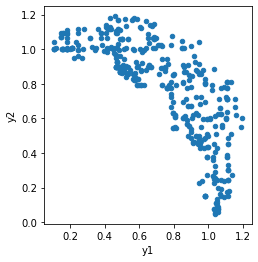

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

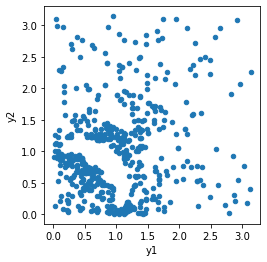

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

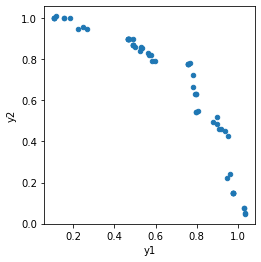

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

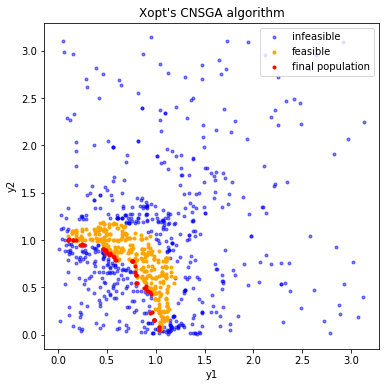

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.json

rm: test.json: No such file or directory
